In [34]:
import sys 
sys.path.append('../src')

In [35]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
# from quantum_circuit import q_net, Quantumnet
from quantum_circuit import q_net, Quantumnet
import pennylane as qml

# Other tools
import time
import os
import copy

from dataset import get_data_transforms, get_dataloaders
from utils import imshow
from training import train_model, visualize_model

env: OMP_NUM_THREADS=1


In [36]:
n_qubits = 4                     # Number of qubits
quantum = True                   # If set to "False", the dressed quantum circuit is replaced by 
                                 # An enterily classical net (defined by the next parameter). 
classical_model = '512_nq_2'     # Possible choices: '512_2','512_nq_2','551_512_2'. 
step = 0.0004                    # Learning rate
batch_size = 4                   # Number of samples for each training step
num_epochs = 30                  # Number of training epochs
q_depth = 6                      # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1         # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights
rng_seed = 0                     # Seed for random number generator
start_time = time.time()         # Start of the computation timer

In [37]:
dev = qml.device('default.qubit', wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {device}")
print(torch.cuda.get_device_name(0))

✅ Usando dispositivo: cuda:0
NVIDIA GeForce RTX 4070 Laptop GPU


In [38]:
data_dir = '../HCQNN/quantum-transfer-learning/data/hymenoptera_data'

data_transforms = get_data_transforms()

torch.manual_seed(rng_seed)

dataloaders, dataset_sizes, class_names = get_dataloaders(
    data_dir=data_dir, batch_size=batch_size, shuffle=True
)

image_datasets = {
    x: dataloaders[x].dataset for x in ['train', 'val']
}

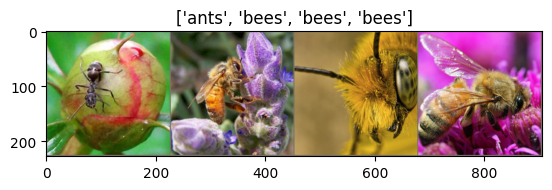

In [39]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# torch.manual_seed(rng_seed)
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                #   batch_size=batch_size,shuffle=True) for x in ['train', 'val']}

In [40]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False
    
if quantum:
    model_hybrid.fc = Quantumnet()
    
elif classical_model == '512_2':
    model_hybrid.fc = nn.Linear(512, 2)
    
elif classical_model == '512_nq_2':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 2)) 

elif classical_model == '551_512_2':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 2))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

c:\Users\Lucas\anaconda3\envs\crema-d\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\crema-d\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
# Definición de la función de pérdida (loss)
criterion = nn.CrossEntropyLoss()

# Definición del optimizador
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

# Definición del scheduler para reducir el learning rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)


In [43]:
model_hybrid = train_model(
    model=model_hybrid,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    criterion=criterion,
    optimizer=optimizer_hybrid,
    scheduler=exp_lr_scheduler,
    num_epochs=num_epochs
)


🚀 Training started:
Phase: train Epoch: 1/30 Loss: 0.5654 Acc: 0.86890.1760s
Phase: val Epoch: 1/30 Loss: 0.5228 Acc: 0.95420.0317s
Phase: train Epoch: 2/30 Loss: 0.5638 Acc: 0.89340.1910s
Phase: val Epoch: 2/30 Loss: 0.5245 Acc: 0.93460.0339s
Phase: train Epoch: 3/30 Loss: 0.5837 Acc: 0.84020.1913s
Phase: val Epoch: 3/30 Loss: 0.5234 Acc: 0.93460.0288s
Phase: train Epoch: 4/30 Loss: 0.5679 Acc: 0.86070.1859s
Phase: val Epoch: 4/30 Loss: 0.5212 Acc: 0.94120.0300s
Phase: train Epoch: 5/30 Loss: 0.5524 Acc: 0.89750.1882s
Phase: val Epoch: 5/30 Loss: 0.5163 Acc: 0.94770.0304s
Phase: train Epoch: 6/30 Loss: 0.5766 Acc: 0.83200.1756s
Phase: val Epoch: 6/30 Loss: 0.5133 Acc: 0.94120.0370s
Phase: train Epoch: 7/30 Loss: 0.5598 Acc: 0.87300.2493s
Phase: val Epoch: 7/30 Loss: 0.5140 Acc: 0.93460.0364s
Phase: train Epoch: 8/30 Loss: 0.5585 Acc: 0.88520.1754s
Phase: val Epoch: 8/30 Loss: 0.5179 Acc: 0.94120.0347s
Phase: train Epoch: 9/30 Loss: 0.5597 Acc: 0.87300.1735s
Phase: val Epoch: 9/30 Loss